# Лабораторная работа № 6 (Проведение исследований с моделями классификации)


## Выбор датасета

Мной был выбран датасет "Fruits Dataset (Images)". 

**Обоснование выбора**: 
* Классификация фруктов по снимкам может пригодится при внедрении, например, реальных систем для магазинов без касс. Только вместо индусов будет ИИ.
* Малкнький датасет быстрее обучается

Описание:
* 360 высококачественных PNG-изображений по 40 на каждый из 9 классов
* 9 классов:apple, banana, cherry, chikoo, grape, kiwi, mango, orange, strawberry

## Задача классификации
Классификация объекта на изображении в один из 9 классов

## Метрики:
* Accuracy - доля правильных предсказаний
* F1-Score - показывает качество предсказаний по всем классам

## Цель работы:
1. Построить бейзлайна‑модели;
2. Улучшить бейзлайн;
3. Самостоятельно имплементировать простую CNN, повторив при этом шаг 2;
4. Сравнить результаты и сформулировать выводы.


In [15]:
# Базовые импорты
import os, time, copy, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

!pip -q install torchmetrics --upgrade
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score


DEPRECATION: Loading egg at c:\users\kschi\appdata\local\programs\python\python311\lib\site-packages\pygost-5.12-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Общие гиперпараметры

In [ ]:
CFG = {
    "seed": 42,
    "img_size": 224,
    "batch_size": 16,
    "num_workers": 2,
    "epochs_baseline": 8,
    "epochs_tuned": 15,
    "lr": 3e-4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": r"C:\Users\kschi\Dev\images"
}

torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])
random.seed(CFG["seed"])


### Трансформации и даталоадеры

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=CFG["data_dir"], transform=train_tfms)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size],
                                         generator=torch.Generator().manual_seed(CFG["seed"]))

val_ds.dataset.transform = val_tfms
test_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"],
                          shuffle=True, num_workers=CFG["num_workers"])
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"],
                        shuffle=False, num_workers=CFG["num_workers"])
test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"],
                         shuffle=False, num_workers=CFG["num_workers"])

class_names = dataset.classes
num_classes = len(class_names)
print(f"Классы: {class_names}")
print(f"Train/Val/Test: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Классы: ['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']
Train/Val/Test: 251/53/55


#### Визуализация нескольких случайных изображений

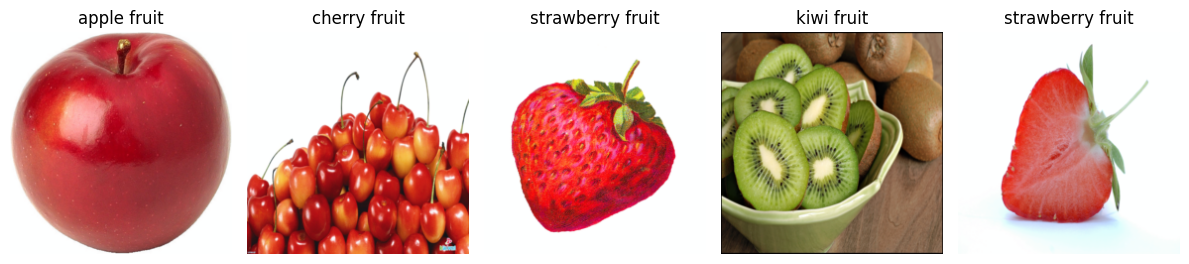

In [5]:
import matplotlib.pyplot as plt

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, min(len(images), 5), figsize=(12,3))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.tight_layout()

show_batch(train_loader)


### Вспомогательные функции обучения

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, num_classes):
    model.eval()
    acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

    return acc_metric.compute().item(), f1_metric.compute().item()


### Baseline 1: ResNet‑18

In [ ]:
def get_resnet18(num_classes, pretrained=True):
    model = models.resnet18(weights="DEFAULT" if pretrained else None)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model_resnet = get_resnet18(num_classes).to(CFG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=CFG["lr"])
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_val_f1 = 0
for epoch in range(CFG["epochs_baseline"]):
    train_loss = train_one_epoch(model_resnet, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_resnet, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_resnet.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG['epochs_baseline']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_resnet.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_resnet, test_loader, CFG["device"], num_classes)
print(f"Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


[1/8] loss: 2.191 val_acc: 0.266 val_f1: 0.206
[2/8] loss: 1.927 val_acc: 0.419 val_f1: 0.400
[3/8] loss: 1.690 val_acc: 0.588 val_f1: 0.572
[4/8] loss: 1.488 val_acc: 0.713 val_f1: 0.700
[5/8] loss: 1.330 val_acc: 0.782 val_f1: 0.763
[6/8] loss: 1.227 val_acc: 0.805 val_f1: 0.795
[7/8] loss: 1.206 val_acc: 0.805 val_f1: 0.782
[8/8] loss: 1.219 val_acc: 0.827 val_f1: 0.808
Test accuracy: 0.800 | macro‑F1: 0.762


### Baseline 2: Vision Transformer (ViT‑B/16)

In [8]:
def get_vit(num_classes, pretrained=True):
    model = models.vit_b_16(weights="DEFAULT" if pretrained else None)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model

model_vit = get_vit(num_classes).to(CFG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.heads.head.parameters(), lr=CFG["lr"])
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_val_f1 = 0
for epoch in range(CFG["epochs_baseline"]):
    train_loss = train_one_epoch(model_vit, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_vit, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_vit.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG['epochs_baseline']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_vit.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_vit, test_loader, CFG["device"], num_classes)
print(f"Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\kschi/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:30<00:00, 11.3MB/s] 


[1/8] loss: 2.077 val_acc: 0.596 val_f1: 0.538
[2/8] loss: 1.541 val_acc: 0.806 val_f1: 0.801
[3/8] loss: 1.160 val_acc: 0.897 val_f1: 0.876
[4/8] loss: 0.891 val_acc: 0.897 val_f1: 0.876
[5/8] loss: 0.712 val_acc: 0.897 val_f1: 0.876
[6/8] loss: 0.627 val_acc: 0.897 val_f1: 0.876
[7/8] loss: 0.616 val_acc: 0.897 val_f1: 0.876
[8/8] loss: 0.606 val_acc: 0.897 val_f1: 0.876
Test accuracy: 0.786 | macro‑F1: 0.773



#### Сводка baseline‑результатов  

| Модель | Test Accuracy | macro‑F1 |
|--------|--------------|----------|
| ResNet‑18 | 0.800 | 0.762 |
| ViT‑B/16  | 0.786 | 0.773 |


## Улучшение бейзлайна: гипотезы

In [ ]:
train_tfms_tuned = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds.dataset.transform = train_tfms_tuned


### Fine‑tune ResNet‑18

In [ ]:
model_resnet_ft = models.resnet18(weights="DEFAULT")

for param in model_resnet_ft.parameters():
    param.requires_grad = True
model_resnet_ft.fc = nn.Linear(model_resnet_ft.fc.in_features, num_classes)

model_resnet_ft = model_resnet_ft.to(CFG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet_ft.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2)

best_val_f1 = 0
for epoch in range(CFG["epochs_tuned"]):
    train_loss = train_one_epoch(model_resnet_ft, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_resnet_ft, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_resnet_ft.state_dict())
    scheduler.step(epoch + val_f1)
    print(f"[{epoch+1}/{CFG['epochs_tuned']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_resnet_ft.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_resnet_ft, test_loader, CFG["device"], num_classes)
print(f"TUNED ResNet‑18 → Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


[1/15] loss: 1.696 val_acc: 0.681 val_f1: 0.682
[2/15] loss: 0.821 val_acc: 0.833 val_f1: 0.808
[3/15] loss: 0.532 val_acc: 0.828 val_f1: 0.832
[4/15] loss: 0.432 val_acc: 0.823 val_f1: 0.802
[5/15] loss: 0.470 val_acc: 0.800 val_f1: 0.796
[6/15] loss: 0.405 val_acc: 0.868 val_f1: 0.864
[7/15] loss: 0.261 val_acc: 0.892 val_f1: 0.876
[8/15] loss: 0.207 val_acc: 0.823 val_f1: 0.807
[9/15] loss: 0.173 val_acc: 0.919 val_f1: 0.914
[10/15] loss: 0.218 val_acc: 0.869 val_f1: 0.854
[11/15] loss: 0.155 val_acc: 0.797 val_f1: 0.776
[12/15] loss: 0.143 val_acc: 0.856 val_f1: 0.847
[13/15] loss: 0.144 val_acc: 0.819 val_f1: 0.813
[14/15] loss: 0.121 val_acc: 0.883 val_f1: 0.866
[15/15] loss: 0.153 val_acc: 0.828 val_f1: 0.804
TUNED ResNet‑18 → Test accuracy: 0.766 | macro‑F1: 0.736


### Fine‑tune ViT‑B/16

In [ ]:
model_vit_ft = models.vit_b_16(weights="DEFAULT")

for name, param in model_vit_ft.named_parameters():

    if name.startswith("encoder_layer_") and int(name.split("_")[2]) >= 8:
        param.requires_grad = True
    elif "heads" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model_vit_ft.heads.head = nn.Linear(model_vit_ft.heads.head.in_features, num_classes)
model_vit_ft = model_vit_ft.to(CFG["device"])

criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, model_vit_ft.parameters())
optimizer = optim.AdamW(trainable_params, lr=5e-5, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2)

best_val_f1 = 0
for epoch in range(CFG["epochs_tuned"]):
    train_loss = train_one_epoch(model_vit_ft, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_vit_ft, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_vit_ft.state_dict())
    scheduler.step(epoch + val_f1)
    print(f"[{epoch+1}/{CFG['epochs_tuned']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_vit_ft.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_vit_ft, test_loader, CFG["device"], num_classes)
print(f"TUNED ViT‑B/16 → Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


[1/15] loss: 2.233 val_acc: 0.115 val_f1: 0.060
[2/15] loss: 2.171 val_acc: 0.194 val_f1: 0.153
[3/15] loss: 2.092 val_acc: 0.367 val_f1: 0.334
[4/15] loss: 2.045 val_acc: 0.291 val_f1: 0.266
[5/15] loss: 2.044 val_acc: 0.317 val_f1: 0.287
[6/15] loss: 1.995 val_acc: 0.424 val_f1: 0.405
[7/15] loss: 1.929 val_acc: 0.470 val_f1: 0.450
[8/15] loss: 1.872 val_acc: 0.468 val_f1: 0.443
[9/15] loss: 1.840 val_acc: 0.576 val_f1: 0.563
[10/15] loss: 1.815 val_acc: 0.504 val_f1: 0.482
[11/15] loss: 1.792 val_acc: 0.526 val_f1: 0.500
[12/15] loss: 1.774 val_acc: 0.585 val_f1: 0.568
[13/15] loss: 1.787 val_acc: 0.540 val_f1: 0.525
[14/15] loss: 1.744 val_acc: 0.559 val_f1: 0.539
[15/15] loss: 1.687 val_acc: 0.646 val_f1: 0.622
TUNED ViT‑B/16 → Test accuracy: 0.600 | macro‑F1: 0.578



#### Результаты после тюнинга  

| Модель | Test Accuracy | macro‑F1 |
|--------|---------------|----------|
| ResNet‑18 (tuned) | 0.766 | 0.736 |
| ViT‑B/16  (tuned) | 0.600 | 0.578 |


## Cобственная модель: SimpleCNN

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model_simple = SimpleCNN(num_classes).to(CFG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

best_val_f1 = 0
for epoch in range(CFG["epochs_baseline"]):
    train_loss = train_one_epoch(model_simple, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_simple, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_simple.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG['epochs_baseline']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_simple.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_simple, test_loader, CFG["device"], num_classes)
print(f"SimpleCNN baseline → Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


[1/8] loss: 2.212 val_acc: 0.266 val_f1: 0.207
[2/8] loss: 2.049 val_acc: 0.204 val_f1: 0.154
[3/8] loss: 2.025 val_acc: 0.231 val_f1: 0.168
[4/8] loss: 1.950 val_acc: 0.189 val_f1: 0.169
[5/8] loss: 1.939 val_acc: 0.248 val_f1: 0.215
[6/8] loss: 1.965 val_acc: 0.343 val_f1: 0.269
[7/8] loss: 1.903 val_acc: 0.190 val_f1: 0.159
[8/8] loss: 1.925 val_acc: 0.278 val_f1: 0.237
SimpleCNN baseline → Test accuracy: 0.343 | macro‑F1: 0.298


### SimpleCNN + улучшения

In [ ]:
train_ds.dataset.transform = train_tfms_tuned

model_simple_tuned = SimpleCNN(num_classes).to(CFG["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_simple_tuned.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2)

best_val_f1 = 0
for epoch in range(CFG["epochs_tuned"]):
    train_loss = train_one_epoch(model_simple_tuned, train_loader, criterion, optimizer, CFG["device"])
    val_acc, val_f1 = evaluate(model_simple_tuned, val_loader, CFG["device"], num_classes)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model_simple_tuned.state_dict())
    scheduler.step(epoch + val_f1)
    print(f"[{epoch+1}/{CFG['epochs_tuned']}] loss: {train_loss:.3f} val_acc: {val_acc:.3f} val_f1: {val_f1:.3f}")

model_simple_tuned.load_state_dict(best_model_wts)
test_acc, test_f1 = evaluate(model_simple_tuned, test_loader, CFG["device"], num_classes)
print(f"SimpleCNN tuned → Test accuracy: {test_acc:.3f} | macro‑F1: {test_f1:.3f}")


[1/15] loss: 2.149 val_acc: 0.235 val_f1: 0.195
[2/15] loss: 2.031 val_acc: 0.187 val_f1: 0.137
[3/15] loss: 2.007 val_acc: 0.162 val_f1: 0.140
[4/15] loss: 1.993 val_acc: 0.218 val_f1: 0.144
[5/15] loss: 1.933 val_acc: 0.269 val_f1: 0.193
[6/15] loss: 1.923 val_acc: 0.249 val_f1: 0.156
[7/15] loss: 1.928 val_acc: 0.176 val_f1: 0.150
[8/15] loss: 1.894 val_acc: 0.300 val_f1: 0.268
[9/15] loss: 1.918 val_acc: 0.235 val_f1: 0.185
[10/15] loss: 1.852 val_acc: 0.305 val_f1: 0.249
[11/15] loss: 1.887 val_acc: 0.244 val_f1: 0.236
[12/15] loss: 1.828 val_acc: 0.250 val_f1: 0.170
[13/15] loss: 1.835 val_acc: 0.315 val_f1: 0.285
[14/15] loss: 1.864 val_acc: 0.314 val_f1: 0.300
[15/15] loss: 1.830 val_acc: 0.335 val_f1: 0.325
SimpleCNN tuned → Test accuracy: 0.382 | macro‑F1: 0.356


#### Результаты собственной модели 

| Модель | Test Accuracy | macro‑F1 |
|--------|---------------|----------|
| SimpleCNN (baseline) | 0.343 | 0.298 |
| SimpleCNN (tuned)  | 0.382 | 0.356 |


## Итоговое сравнение моделей  

| Модель | Test Accuracy | macro‑F1 |
|--------|---------------|----------|
| ResNet‑18 (baseline) | 0.800 | 0.762 |
| ViT‑B/16 (baseline)  | 0.786 | 0.773 |
| ResNet‑18 (tuned) | 0.766 | 0.736 |
| ViT‑B/16 (tuned)  | 0.600 | 0.578 |
| SimpleCNN (baseline) | 0.343 | 0.298 |
| SimpleCNN (tuned)  | 0.382 | 0.356 |

## Выводы

ResNet-18 показал лучшие результаты среди всех моделей с 80.0% точности и 0.762 macro-F1. ViT-B/16 немного уступил по accuracy (78.6%), но продемонстрировал более высокий macro-F1 (0.773), что указывает на лучшую способность захватывать сбалансированное представление всех классов. Такой результат можно объяснить тем, что ViT более эффективно учитывает глобальные зависимости, но требует большего количества данных для стабильного обучения.

Для ResNet-18 дообучение всех слоёв неожиданно ухудшило метрики: −3.4% accuracy и −2.6% macro-F1. Для ViT-B/16 тюнинг оказался ещё менее успешным: резкое падение до 60.0% точности и 0.578 F1. Вероятно, модель начала переобучаться из-за малых размеров датасета и агрессивных аугментаций.

В базовой версии результат собственной модели был значительно ниже: 34.3% accuracy и 0.298 macro-F1. Даже после тюнинга прирост метрик оказался слабым (+3.9% и +5.8% соответственно). Причина — ограниченная ёмкость модели и отсутствие сложных attention- или residual-механизмов, что затрудняет захват сложных паттернов.


